## LSTM模型

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### 資料集載入

In [2]:

# 訓練資料、測試資料
train_df = pd.read_csv('Dataset/DailyDelhiClimateTrain.csv')
test_df = pd.read_csv('Dataset/DailyDelhiClimateTest.csv')

# 查看資料結構
print(train_df.head())

         date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000


### 資料前處理

In [3]:
# 獲取特徵和結果標籤
train_features = train_df[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].values.astype(np.float32)
train_labels = train_df['meantemp'].values.astype(np.float32)
test_features = test_df[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].values.astype(np.float32)
test_labels = test_df['meantemp'].values.astype(np.float32)
# 對資料進行標準化
scaler_features = MinMaxScaler()
scaler_labels = MinMaxScaler()

train_features = scaler_features.fit_transform(train_features)
test_features = scaler_features.transform(test_features)

train_labels = scaler_labels.fit_transform(train_labels.reshape(-1, 1))
test_labels = scaler_labels.transform(test_labels.reshape(-1, 1))

train_features_with_labels = np.hstack((train_features, train_labels))
test_features_with_labels = np.hstack((test_features, test_labels))



# 生成滑動窗口資料
def create_sequences(features, window_size):
    sequences = []
    for i in range(len(features) - window_size):
        seq_features = features[i:i + window_size, :-1]  # 修正為去掉標籤的特徵欄位
        seq_label = features[i + window_size, -1]  # 標籤是最後一列
        sequences.append((seq_features, seq_label))
    return sequences

time_step = 7 # 設定時間長度(前10)

train_sequences = create_sequences(train_features_with_labels, time_step)
test_sequences = create_sequences(test_features_with_labels, time_step)

In [4]:

# 將資料轉換為 PyTorch Tensor
def convert_to_tensor(sequences):
    features, labels = zip(*sequences)
    features = torch.tensor(features, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32)
    return features, labels

train_features_tensor, train_labels_tensor = convert_to_tensor(train_sequences)
test_features_tensor, test_labels_tensor = convert_to_tensor(test_sequences)

C:\Users\a5839\AppData\Local\Temp\ipykernel_24756\1034556782.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  features = torch.tensor(features, dtype=torch.float32)


In [5]:

# 創建 DataLoader
batch_size = 64
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 建立 & 訓練LSTM模型

In [7]:
# 定義LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size # 隱藏層
        self.num_layers = num_layers # 層數
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM前向傳播
        out, _ = self.lstm(x, (h0, c0))

        # 取最後一個時間步的輸出
        out = self.fc(out[:, -1, :])
        return out

input_size = 4      # 每個時間步的輸入特徵數量
hidden_size = 64    # 隱藏層大小
num_layers = 2      # LSTM層數
output_size = 1     # 輸出大小

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to('cuda' if torch.cuda.is_available() else 'cpu')

# 定義損失函數和優化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練模型
num_epochs = 50
for epoch in range(num_epochs):
    for features, labels in train_loader:
        features, labels = features.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')
        
        outputs = model(features)
        loss = criterion(outputs, labels.unsqueeze(1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 0.1719
Epoch [2/50], Loss: 0.0352
Epoch [3/50], Loss: 0.0337
Epoch [4/50], Loss: 0.0337
Epoch [5/50], Loss: 0.0197
Epoch [6/50], Loss: 0.0089
Epoch [7/50], Loss: 0.0099
Epoch [8/50], Loss: 0.0075
Epoch [9/50], Loss: 0.0068
Epoch [10/50], Loss: 0.0060
Epoch [11/50], Loss: 0.0055
Epoch [12/50], Loss: 0.0051
Epoch [13/50], Loss: 0.0048
Epoch [14/50], Loss: 0.0046
Epoch [15/50], Loss: 0.0045
Epoch [16/50], Loss: 0.0045
Epoch [17/50], Loss: 0.0046
Epoch [18/50], Loss: 0.0046
Epoch [19/50], Loss: 0.0046
Epoch [20/50], Loss: 0.0046
Epoch [21/50], Loss: 0.0046
Epoch [22/50], Loss: 0.0046
Epoch [23/50], Loss: 0.0045
Epoch [24/50], Loss: 0.0045
Epoch [25/50], Loss: 0.0045
Epoch [26/50], Loss: 0.0045
Epoch [27/50], Loss: 0.0045
Epoch [28/50], Loss: 0.0045
Epoch [29/50], Loss: 0.0045
Epoch [30/50], Loss: 0.0045
Epoch [31/50], Loss: 0.0044
Epoch [32/50], Loss: 0.0044
Epoch [33/50], Loss: 0.0044
Epoch [34/50], Loss: 0.0043
Epoch [35/50], Loss: 0.0043
Epoch [36/50], Loss: 0.0043
E

### 模型評估

Test Loss: 0.0053
MSE: 5.5765
RMSE: 2.3615
MAE: 2.0048
R^2 Score: 0.8651


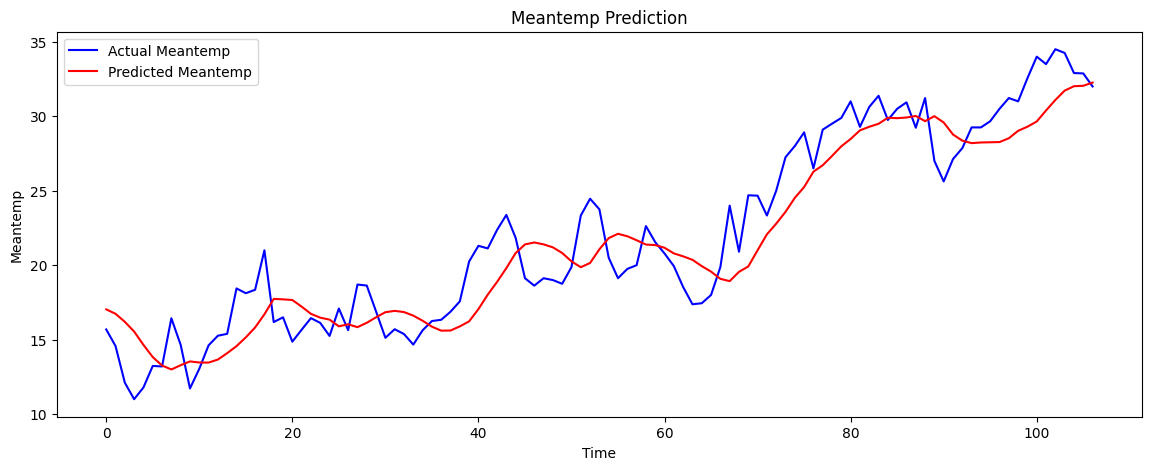

Actual: 15.68, Predicted: 17.03, Difference: 1.35
Actual: 14.57, Predicted: 16.74, Difference: 2.16
Actual: 12.11, Predicted: 16.20, Difference: 4.09
Actual: 11.00, Predicted: 15.54, Difference: 4.54
Actual: 11.79, Predicted: 14.65, Difference: 2.86
Actual: 13.24, Predicted: 13.83, Difference: 0.59
Actual: 13.20, Predicted: 13.26, Difference: 0.06
Actual: 16.43, Predicted: 13.00, Difference: 3.44
Actual: 14.65, Predicted: 13.28, Difference: 1.37
Actual: 11.72, Predicted: 13.54, Difference: 1.82
Actual: 13.04, Predicted: 13.46, Difference: 0.42
Actual: 14.62, Predicted: 13.46, Difference: 1.16
Actual: 15.26, Predicted: 13.66, Difference: 1.60
Actual: 15.39, Predicted: 14.09, Difference: 1.30
Actual: 18.44, Predicted: 14.56, Difference: 3.88
Actual: 18.12, Predicted: 15.15, Difference: 2.97
Actual: 18.35, Predicted: 15.82, Difference: 2.53
Actual: 21.00, Predicted: 16.70, Difference: 4.30
Actual: 16.18, Predicted: 17.73, Difference: 1.55
Actual: 16.50, Predicted: 17.71, Difference: 1.21


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 模型評估
model.eval()
predictions = []

with torch.no_grad():
    test_loss = 0
    for features, labels in test_loader:
        features, labels = features.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')
        
        outputs = model(features)
        loss = criterion(outputs, labels.unsqueeze(1))
        test_loss += loss.item()
        
        predictions.append(outputs.cpu().numpy())
    
    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss:.4f}')
    
    predictions = np.concatenate(predictions, axis=0)

# 還原標籤數據
predictions = scaler_labels.inverse_transform(predictions)
y_test = scaler_labels.inverse_transform(test_labels_tensor.numpy().reshape(-1, 1))

# 計算精確度指標
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R^2 Score: {r2:.4f}')

# 可視化結果
plt.figure(figsize=(14, 5))
plt.plot(y_test, color='blue', label='Actual Meantemp')
plt.plot(predictions, color='red', label='Predicted Meantemp')
plt.title('Meantemp Prediction')
plt.xlabel('Time')
plt.ylabel('Meantemp')
plt.legend()
plt.show()

# 展開看誤差
for i in range(len(predictions)):
    actual = y_test[i][0]  # 獲取原始數值
    predicted = predictions[i][0]  # 獲取原始數值
    difference = abs(actual - predicted)
    print(f'Actual: {actual:.2f}, Predicted: {predicted:.2f}, Difference: {difference:.2f}')


## 完整版(有標準化)

Epoch [1/200], Loss: 0.0445
Epoch [2/200], Loss: 0.0273
Epoch [3/200], Loss: 0.0068
Epoch [4/200], Loss: 0.0073
Epoch [5/200], Loss: 0.0062
Epoch [6/200], Loss: 0.0053
Epoch [7/200], Loss: 0.0041
Epoch [8/200], Loss: 0.0046
Epoch [9/200], Loss: 0.0039
Epoch [10/200], Loss: 0.0039
Epoch [11/200], Loss: 0.0039
Epoch [12/200], Loss: 0.0037
Epoch [13/200], Loss: 0.0041
Epoch [14/200], Loss: 0.0041
Epoch [15/200], Loss: 0.0041
Epoch [16/200], Loss: 0.0030
Epoch [17/200], Loss: 0.0030
Epoch [18/200], Loss: 0.0045
Epoch [19/200], Loss: 0.0043
Epoch [20/200], Loss: 0.0043
Epoch [21/200], Loss: 0.0025
Epoch [22/200], Loss: 0.0040
Epoch [23/200], Loss: 0.0042
Epoch [24/200], Loss: 0.0031
Epoch [25/200], Loss: 0.0026
Epoch [26/200], Loss: 0.0034
Epoch [27/200], Loss: 0.0036
Epoch [28/200], Loss: 0.0023
Epoch [29/200], Loss: 0.0038
Epoch [30/200], Loss: 0.0028
Epoch [31/200], Loss: 0.0034
Epoch [32/200], Loss: 0.0027
Epoch [33/200], Loss: 0.0031
Epoch [34/200], Loss: 0.0034
Epoch [35/200], Loss: 0

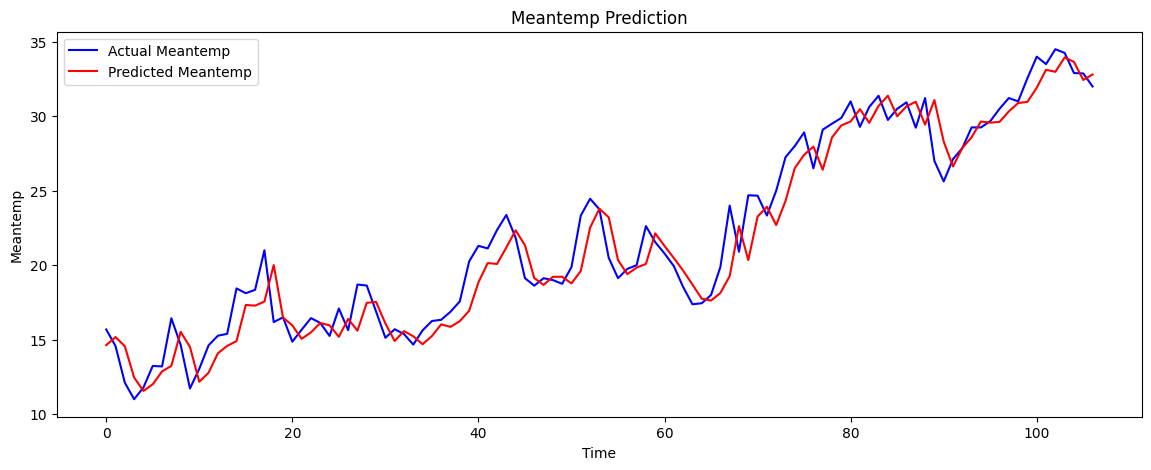

In [67]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 讀取訓練和測試數據
train_data = pd.read_csv('Dataset/DailyDelhiClimateTrain.csv')
test_data = pd.read_csv('Dataset/DailyDelhiClimateTest.csv')

# 提取特徵和結果標籤
train_features = train_data[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].values.astype(np.float32)
train_labels = train_data['meantemp'].values.astype(np.float32)
test_features = test_data[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].values.astype(np.float32)
test_labels = test_data['meantemp'].values.astype(np.float32)

# 對資料進行標準化
scaler_features = MinMaxScaler()
scaler_labels = MinMaxScaler()

train_features = scaler_features.fit_transform(train_features)
test_features = scaler_features.transform(test_features)

train_labels = scaler_labels.fit_transform(train_labels.reshape(-1, 1))
test_labels = scaler_labels.transform(test_labels.reshape(-1, 1))

train_features_with_labels = np.hstack((train_features, train_labels))
test_features_with_labels = np.hstack((test_features, test_labels))

# 生成滑動窗口資料
def create_sequences(features, window_size):
    sequences = []
    for i in range(len(features) - window_size):
        seq_features = features[i:i + window_size, :-1]
        seq_label = features[i + window_size, -1]  # 標籤是最後一列
        sequences.append((seq_features, seq_label))
    return sequences

time_step = 7 # 設定時間長度(前7天)

train_sequences = create_sequences(train_features_with_labels, time_step)
test_sequences = create_sequences(test_features_with_labels, time_step)

# 分解序列特徵和標籤
train_sequences_features = np.array([seq[0] for seq in train_sequences])
train_sequences_labels = np.array([seq[1] for seq in train_sequences])

test_sequences_features = np.array([seq[0] for seq in test_sequences])
test_sequences_labels = np.array([seq[1] for seq in test_sequences])

# 將numpy數據轉換為PyTorch張量
train_sequences_tensor = torch.tensor(train_sequences_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_sequences_labels, dtype=torch.float32)
test_sequences_tensor = torch.tensor(test_sequences_features, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_sequences_labels, dtype=torch.float32)

# 創建DataLoader
batch_size = 64
train_dataset = TensorDataset(train_sequences_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_sequences_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 定義LSTM模型
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # 只取最後一個時間步的輸出
        return out

# 設定模型參數
input_size = 4
hidden_size = 64
num_layers = 2
output_size = 1

# 初始化模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

# 定義損失函數和優化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 訓練模型
num_epochs = 200
model.train()
for epoch in range(num_epochs):
    for batch_inputs, batch_targets in train_loader:
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

        # 前向傳播
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets.unsqueeze(1))

        # 反向傳播和優化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# 評估模型
model.eval()
test_loss = 0
all_targets = []
all_predictions = []

with torch.no_grad():
    for batch_inputs, batch_targets in test_loader:
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
        outputs = model(batch_inputs)
        test_loss += criterion(outputs, batch_targets.unsqueeze(1)).item()
        all_targets.extend(batch_targets.cpu().numpy())
        all_predictions.extend(outputs.cpu().numpy())

mean_test_loss = test_loss / len(test_loader)
mse = mean_squared_error(all_targets, all_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_targets, all_predictions)
r2 = r2_score(all_targets, all_predictions)

print(f'Test Loss: {mean_test_loss:.4f}')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R^2 Score: {r2:.4f}')

# 還原標籤數據
all_targets = scaler_labels.inverse_transform(np.array(all_targets).reshape(-1, 1)).flatten()
all_predictions = scaler_labels.inverse_transform(np.array(all_predictions).reshape(-1, 1)).flatten()

# 顯示部分預測結果
print(all_targets[:5])
print(all_predictions[:5])

# 可視化結果
plt.figure(figsize=(14, 5))
plt.plot(all_targets, color='blue', label='Actual Meantemp')
plt.plot(all_predictions, color='red', label='Predicted Meantemp')
plt.title('Meantemp Prediction')
plt.xlabel('Time')
plt.ylabel('Meantemp')
plt.legend()
plt.show()


## 完整版

In [65]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# 讀取訓練和測試數據
train_data = pd.read_csv('Dataset/DailyDelhiClimateTrain.csv')
test_data = pd.read_csv('Dataset/DailyDelhiClimateTest.csv')

# 提取特徵
train_np = train_data[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].values.astype(np.float32)
test_np = test_data[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].values.astype(np.float32)

# 創建滑動窗口
def create_sequences(input_data, window_size):
    sequences = []
    for i in range(len(input_data) - window_size):
        sequence = input_data[i:i + window_size]
        sequences.append(sequence)
    return np.array(sequences)

# 設定滑動窗口大小
window_size = 7

# 生成訓練和測試數據的滑動窗口
train_sequences = create_sequences(train_np, window_size)
test_sequences = create_sequences(test_np, window_size)

# 將numpy數據轉換為PyTorch張量
train_sequences_tensor = torch.tensor(train_sequences, dtype=torch.float32)
test_sequences_tensor = torch.tensor(test_sequences, dtype=torch.float32)

# 創建標籤
train_targets_tensor = torch.tensor(train_data['meantemp'][window_size:].values.astype(np.float32))
test_targets_tensor = torch.tensor(test_data['meantemp'][window_size:].values.astype(np.float32))

# 創建DataLoader
batch_size = 64
train_dataset = TensorDataset(train_sequences_tensor, train_targets_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_sequences_tensor, test_targets_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 定義LSTM模型
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # 只取最後一個時間步的輸出
        return out

# 設定模型參數
input_size = 4
hidden_size = 64
num_layers = 2
output_size = 1

# 初始化模型
model = LSTM(input_size, hidden_size, num_layers, output_size).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# 定義損失函數和優化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 訓練模型
num_epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.train()
for epoch in range(num_epochs):
    for batch_inputs, batch_targets in train_loader:
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

        # 前向傳播
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets.unsqueeze(1))

        # 反向傳播和優化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# 評估模型
model.eval()
test_loss = 0
all_targets = []
all_predictions = []

with torch.no_grad():
    for batch_inputs, batch_targets in test_loader:
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
        outputs = model(batch_inputs)
        test_loss += criterion(outputs, batch_targets.unsqueeze(1)).item()
        all_targets.extend(batch_targets.cpu().numpy())
        all_predictions.extend(outputs.cpu().numpy())

mean_test_loss = test_loss / len(test_loader)
mse = mean_squared_error(all_targets, all_predictions)
r2 = r2_score(all_targets, all_predictions)

print(f'Test Loss: {mean_test_loss:.4f}')
print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')

# 顯示部分預測結果
print(all_targets[:5])
print(all_predictions[:5])


Epoch [1/200], Loss: 564.0873
Epoch [2/200], Loss: 406.6908
Epoch [3/200], Loss: 331.4517
Epoch [4/200], Loss: 287.7669
Epoch [5/200], Loss: 269.3145
Epoch [6/200], Loss: 182.6048
Epoch [7/200], Loss: 208.0557
Epoch [8/200], Loss: 131.4041
Epoch [9/200], Loss: 111.5794
Epoch [10/200], Loss: 110.6002
Epoch [11/200], Loss: 99.2447
Epoch [12/200], Loss: 80.6328
Epoch [13/200], Loss: 85.0766
Epoch [14/200], Loss: 63.7913
Epoch [15/200], Loss: 63.3429
Epoch [16/200], Loss: 63.7852
Epoch [17/200], Loss: 61.0919
Epoch [18/200], Loss: 64.6015
Epoch [19/200], Loss: 55.1107
Epoch [20/200], Loss: 70.2892
Epoch [21/200], Loss: 57.2103
Epoch [22/200], Loss: 51.7697
Epoch [23/200], Loss: 53.8584
Epoch [24/200], Loss: 56.3557
Epoch [25/200], Loss: 46.0757
Epoch [26/200], Loss: 63.8767
Epoch [27/200], Loss: 61.1634
Epoch [28/200], Loss: 57.6871
Epoch [29/200], Loss: 65.5630
Epoch [30/200], Loss: 43.7628
Epoch [31/200], Loss: 51.8881
Epoch [32/200], Loss: 55.4005
Epoch [33/200], Loss: 51.5436
Epoch [34

Test Loss: 3.4680
MSE: 3.6577
RMSE: 7.2271
MAE: 6.4331
R^2 Score: 0.9115
[15.684211, 14.571428, 12.111111, 11.0, 11.789474]
[array([21.250511], dtype=float32), array([16.270761], dtype=float32), array([16.025204], dtype=float32), array([14.500513], dtype=float32), array([13.592289], dtype=float32)]


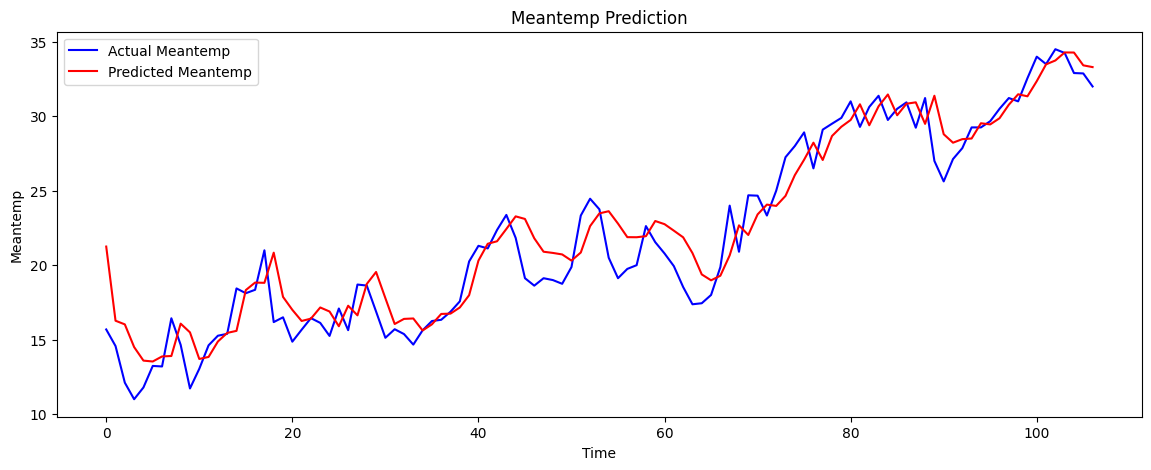

In [66]:

print(f'Test Loss: {mean_test_loss:.4f}')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R^2 Score: {r2:.4f}')

# 顯示部分預測結果
print(all_targets[:5])
print(all_predictions[:5])

# 可視化結果
plt.figure(figsize=(14, 5))
plt.plot(all_targets, color='blue', label='Actual Meantemp')
plt.plot(all_predictions, color='red', label='Predicted Meantemp')
plt.title('Meantemp Prediction')
plt.xlabel('Time')
plt.ylabel('Meantemp')
plt.legend()
plt.show()